# Intro to Recurrent Neural Networks

Recurrent Neural Networks (RNN) are another specialization within the neural network family designed to work specifically with sequence data. The most common types of data to use with RNN's are time series data and textual data (natural language, programming languages, log files, and so on).

Sequence data, and especially variable length sequence data, presents significant challenges for other models in the neural network family (and many other kinds of models) for a few reasons including:

### Most models, ANN's included, require a fixed input size.

This is fine for some problems, looking at a fixed-size time window for weather prediction is perfectly reasonable. But it's a non-starter for problems like machine translation where arbitrary text documents (from single sentences to complete books) must be handled for the system to be worth anything. 

Earlier models working with sequence data often involved a preprocessing step that smashes variable length data into a fixed length feature vector. One of the simplest examples of this tactic is called the "Bag of Words" where a textual input is reduced to the number of times any given word appears in that data-point. The result of a "Bag of Words" transformation is a vector where each position represents one of the words in the entire corpus vocabulary, the integer value in that position represents how many times that word occurs in the data-point.  

This enconding for text is problimatic and limiting, as we discussed previously. For example, "live to work" and "work to live"  will result in the same "bag of words" encoding although all English speakers recognize the sentences are opposites of each other. 

One dimenstional CNN's can be used to solve this problem to some extent, although they are somewhat limited by the kernel size with respect to how far backwards in the sequence they can look at once. 

### Most models, including ANN's requre a fixed output size.

Similar to the above many sequence tasks (such as machine translation) require arbitrary length output, which is a non-starter for both ANNs and CNNs.

## RNNs Solve These Problems By Maintaining Internal State

The core idea of an RNN makes a lot of people raise their eyebrows at first, but it is actually quite simple. In addition to the weights and biases used in a traditional ANN, the RNN introduces a "state vector" which is internal to the recurrent nodes. This is sometimes drawn in a confusing way such as this illustration from [one of the readings](https://towardsdatascience.com/illustrated-guide-to-recurrent-neural-networks-79e5eb8049c9):

![](https://miro.medium.com/max/106/1*h_cfQuMl30szUkDAi7wrCA.png)

The idea is that this node is passing some information *to itself* across a series of sequental calls, one for each data point in the sequence (this could be time steps in a time series, words in a sentence, or characters in a string of text). 

This is true, but I think it's easier to imagine the state vector as a piece of memory internal to the node which is  updated (even during inference) for each piece of data in the input sequence:


![](assets/single-rnn-node.png)

X0 is the first input of the sequence (e.g. first word, first time step, or first character), y0 is the cell's output, and the state vector, like the weights matrix, is internal to the cell. However, unlike the weights, the state vector changes during forward passes instead of just during back-propagation. So, when we move on to the second piece of data in the sequence we have something like this:

![](assets/two-rnn-node.png)

The forward pass on datapoint X0 modified the internal state vector, so this is often drawn with an arrow connecting the whole cell to itself in a subsequent timestep, such as this drawing, from [another one of the readings](https://karpathy.github.io/2015/05/21/rnn-effectiveness/):

![](https://karpathy.github.io/assets/rnn/diags.jpeg)

The hidden state vector contains all the information that the network has accumulated about the sequence so far. Similar to a markov chain, RNN's implicitly assume that this vector is rich enough to capture all the relevant information about what has been processed earlier in the sequence (for examples, which words have already been seen).

The forward pass for a vanilla RNN works like this (assuming an activation function of tanh):

```
# Hidden state is updated:
#   W_hh (the weights for the hidden state vector)
#   W_xh (the weights for x)
#   self.h (the actual hidden state)
self.h = np.tanh(np.dot(self.W_hh, self.h) + np.dot(self.W_xh, x))

# Compute the output
#   self.W_xy (the weights for the output)
y = np.dot(self.W_hy, self.h)

return y
```

The output y can be passed to other neural network layers as usual, and the hidden state is carried over across the current sequence (but is reinitialized for each new sequence, usually to zero!) 

**Note** that there are 3 sets of weights:

* One that learns to transform the hidden state each timestep,
* One that learns to transform to the X input data at each timestep,
* One that learns to create the output based on the hidden state at each timestep.

## Backpropagation Over Time

To understand how backpropagation works with these models, it's best to think about "unrolling" the model as we saw in the diagram above:


![](https://karpathy.github.io/assets/rnn/diags.jpeg)

For each output, we compute a loss and the gradients flow backwards through the entire "unrolled" network. This has a few implications:

* The shared weight matricies are updated multiple times per backprop step. 
    * This exacerbates the exploding and vanishing gradient problems.
* It makes the model memory intensive during training, since the hidden states at each timestep have to be retained during training (but not during inference).
* Training is typically slow, since both during the forward passes and backpropagation there are dependencies over time — e.g. you must finish calculating the values for x0 before computing the values for x1, meaning we cannot leverage parallelism and GPU hardware nearly as well as we could with CNNs and ANNs.


## Okay, Lets Build our First RNN:

As usual, Tensorflow makes things super easy:

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential()

# Add an Embedding layer expecting input vocab of size 1000, and
# output embedding dimension of size 64, meaning a vector with 64 values.
model.add(layers.Embedding(input_dim=1000, output_dim=64))

# Add a Simple RNN layer with 128 internal units.
# This means the "hidden state" will be a 128 length vector!
model.add(layers.SimpleRNN(128)) # Default activation is Tanh

# Lets say we're building a binary classification system...
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          64000     
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 128)               24704     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 88,833
Trainable params: 88,833
Non-trainable params: 0
_________________________________________________________________


## Preparing training data

We're going to use a dataset from the wonderful `tensorflow-datasets` package, a collection of IMDB reviews.

In [2]:
import tensorflow_datasets as tfds

# Grab the reviews and extra information
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)

# Split them into train/test
train_dataset, test_dataset = dataset['train'], dataset['test']


# Lets look at some examples from the dataset
for example, label in train_dataset.take(5):
    print('text: ', example.numpy()) # .numpy here grabs the value inside a tensor, and has to do with the Dataset class
    print('label: ', label.numpy())
    print('\n\n')

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0



text:  b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbis

In [3]:
# A couple tensorflow oddities.
# Shuffle the dataset is always a good idea for optimization purposes.
# And giving the data a batch size is required for fit.
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

# Vectorization And Embedding

Although we said earlier that embedding layers take words as input, that's not quite true. In fact they expect a single integer representing the word. We're going to use a TextVectorization class to create this mapping. This mapping has nothing to do with semantic meaning, instead it simply maps a word to an integer based on the order that they appear in our training dataset, or by their frequency (e.g. most frequent word -> 0, second most -> 1, third most -> 2, and so on).

We can specify a vocabulary size, which will place a limit on how many words get mappings, other words will be mapped to a special token meaning "unknown word" which will also be used anytime a word appears in the test set that wasn't in the training set (a common problem with proper nouns, for example).

In [4]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# Setting a max vocab size of 1000 will cause the 1000 most common words
# to get tokens, and anything else to map to the out-of-vocabulary or UNK token.
VOCAB_SIZE=1000

encoder = TextVectorization(max_tokens=VOCAB_SIZE)

# Adapt fits the encoder to the training data
# The map function is mapping a (text, label) tuple to just the text, and is an 
# idiosyncrasy of the tf Dataset class.
encoder.adapt(train_dataset.map(lambda text, label: text))

In [7]:
# Print the first 20 values of the vocabulary
vocab = np.array(encoder.get_vocabulary())
print(vocab[:20])
print('\n\n')

# Print a sample and its numeric representation.
for batch, batch_labels in train_dataset.take(1):
    example = batch[0]
    encoded_example = encoder(example).numpy()
    print(example.numpy())
    print(encoded_example)
    print()

['' '[UNK]' 'the' 'and' 'a' 'of' 'to' 'is' 'in' 'it' 'i' 'this' 'that'
 'br' 'was' 'as' 'for' 'with' 'movie' 'but']



b'In the film Kongwon-do ui him it features a relatively intimate look into the meaningfulness (as well as general meaninglessness) into the lives of various Koreans; empty people seeking ways to fill themselves, enjoying the escapism of nature. From the beginning to the end of the film we observe the fallibility of the various characters; we learn of their shortcomings and their desires, the overall complexity captured within human life (and yet the overal simplicity of humanity). Although the film is slow-moving, it can be very contemplative. It does not force any ideas, but allows the ideas to come about themselves, it allows the concepts to reveal themselves.<br /><br />The film ends as well and as suddenly as it begins, and one truly understands the meaning of aloneness, that love is often an act of selfishness, and the many mistakes that we make. It is a look int

## Rebuild our RNN With the Text Vectorization

Now we need to add our text vectorization step to the model. Alternatively, we could manually transform our data using the encoder before training, which may save a bit of time ultimately but isn't as pretty in the code.

In [8]:
# This might be the first time we've used this style of initializing the model
# where we pass the layers as an array to the Sequential constructor...
model = keras.Sequential([
    encoder,
    # Mask_zero is required to support variable length input
    layers.Embedding(input_dim=len(encoder.get_vocabulary()), output_dim=64, mask_zero=True),
    layers.SimpleRNN(128, return_sequences=False),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=['accuracy']
)

history = model.fit(
    train_dataset, 
    epochs=10,
    validation_data=test_dataset, 
    validation_steps=30
)

Epoch 1/10
391/391 [==============================] - 139s 352ms/step - loss: 0.6928 - accuracy: 0.5166 - val_loss: 0.6955 - val_accuracy: 0.4938
Epoch 2/10
391/391 [==============================] - 131s 335ms/step - loss: 0.6912 - accuracy: 0.5217 - val_loss: 0.6892 - val_accuracy: 0.5562
Epoch 3/10
391/391 [==============================] - 130s 333ms/step - loss: 0.6779 - accuracy: 0.5736 - val_loss: 0.6884 - val_accuracy: 0.5479
Epoch 4/10
391/391 [==============================] - 127s 324ms/step - loss: 0.6639 - accuracy: 0.6154 - val_loss: 0.5283 - val_accuracy: 0.7552
Epoch 5/10
391/391 [==============================] - 124s 318ms/step - loss: 0.4547 - accuracy: 0.8010 - val_loss: 0.3788 - val_accuracy: 0.8328
Epoch 6/10
391/391 [==============================] - 123s 315ms/step - loss: 0.3562 - accuracy: 0.8477 - val_loss: 0.5333 - val_accuracy: 0.7359
Epoch 7/10
391/391 [==============================] - 125s 319ms/step - loss: 0.3626 - accuracy: 0.8479 - val_loss: 0.3927 -

## Note:

RNN's are SLOW to train, even this very small model took 2 minutes per epoch. Making matters worse, because RNNs by their nature have dependency over "time" (in our case later words in the sentence depend on earlier words) the training and inference processes are not nearly as parallelizable as other models like CNNs.

This is one of the reasons that Transformers have become popular in recent years for similar tasks. Similarly, some specialized CNN architectures are also performing quite well on sequence tasks, but are much less costly to train as they take much better advantage of modern GPU/TPU chip design.

391/391 [==============================] - 38s 97ms/step - loss: 0.3543 - accuracy: 0.8474
Test Loss: 0.3543233871459961
Test Accuracy: 0.8474000096321106


(0.0, 0.715691140294075)

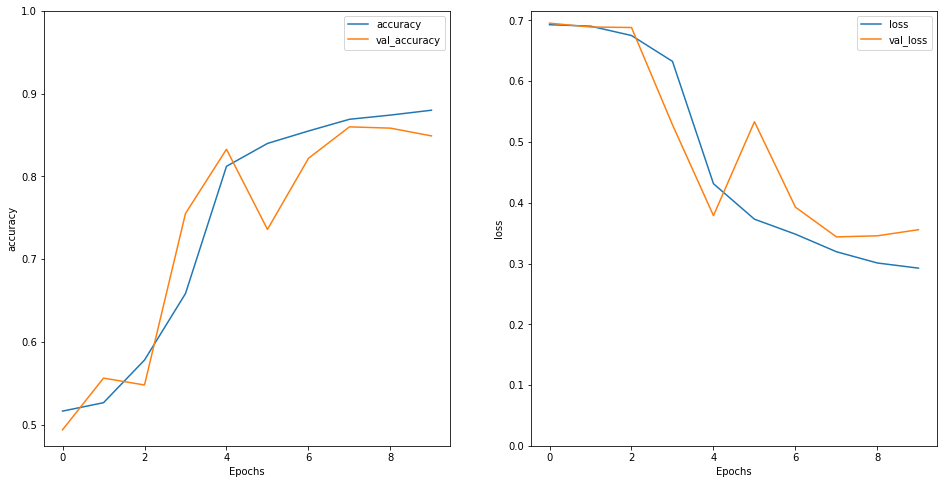

In [9]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    


test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.ylim(None,1)
plt.subplot(1,2,2)
plot_graphs(history, 'loss')
plt.ylim(0,None)


## Mini Exercise: Build One

Build and train an RNN of your own that uses more than one SimpleRNN layer stacked on top of each other. Note that on the first of these stacked layers you'll need to change the return_sequence parameter to true: `layers.SimpleRNN(128, return_sequences=True)`

This change causes the first RNN layer to produce an output at every timestep, whereas when it is set to false we were only returning an output after all the items in the sequence had been processed. (see the above many-to-one diagram for a visualization). You'd also want to use this parameter when you're using an RNN to predict a sequence, rather than a single value (see one to many, many to many in the above diagram).